In [1]:
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
from sklearn.model_selection import train_test_split
from PIL import Image
import os

dataset_path = './dataset/UTKFace/'
file_list = os.listdir(dataset_path)

ages = [int(file.split('_')[0]) for file in file_list]
genders = [int(file.split('_')[1]) for file in file_list]  # 0 for Male, 1 for Female
df = pd.DataFrame({'filename': file_list, 'age': ages, 'gender': genders})

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Ridimensiona le immagini a 64x64
    transforms.ToTensor(),         # Converte le immagini in tensori
])

class UTKFaceDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        age = self.dataframe.iloc[idx, 1]
        gender = self.dataframe.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)

        return image, gender, age

# Crea istanze del dataset per addestramento e test
train_dataset = UTKFaceDataset(dataframe=train_df, root_dir=dataset_path, transform=transform)
test_dataset = UTKFaceDataset(dataframe=test_df, root_dir=dataset_path, transform=transform)

# Crea DataLoader per iterare sui dati durante l'addestramento
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class GenderAgeClassifier(nn.Module):
    def __init__(self):
        super(GenderAgeClassifier, self).__init__()

        # CNN architecture
        self.shared_cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Dimensione dell'output dopo le CNN

        # Branca per il genere
        self.gender_fc1 = nn.Linear(2048, 128)
        self.gender_fc2 = nn.Linear(128, 2)  # 2 classi per il genere (maschio o femmina)

        # Branca per l'età
        self.age_fc1 = nn.Linear(2048, 128)
        self.age_fc2 = nn.Linear(128, 1)  # 1 output per l'età (regressione)

    def forward(self, x):
        # Implementa la logica di propagazione in avanti
        cnn_output = self.shared_cnn(x)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)

        #print("Dimensione di cnn_output:", cnn_output.size())

        # Branca per il genere
        #print("Dimensione di gender_fc1 weight:", self.gender_fc1.weight.size())
        #print("Dimensione di gender_fc1 bias:", self.gender_fc1.bias.size())
        gender_output = F.relu(self.gender_fc1(cnn_output))
        #print("Dimensione di gender_output:", gender_output.size())
        gender_output = self.gender_fc2(gender_output)

        # Branca per l'età
        #print("Dimensione di age_fc1 weight:", self.age_fc1.weight.size())
        #print("Dimensione di age_fc1 bias:", self.age_fc1.bias.size())
        age_output = F.relu(self.age_fc1(cnn_output))
        #print("Dimensione di age_output:", age_output.size())
        age_output = self.age_fc2(age_output)

        return gender_output, age_output


# Inizializza il modello
model = GenderAgeClassifier()

In [4]:
criterion_gender = nn.CrossEntropyLoss()
criterion_age = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
from sklearn.metrics import r2_score

# Numero massimo di epoche di addestramento
num_epochs = 50

# Liste per salvare l'andamento della perdita
train_loss_list = []
test_loss_list = []

# Liste per salvare l'andamento dell'accuratezza
train_gender_accuracy_list = []
test_gender_accuracy_list = []
train_age_accuracy_list = []
test_age_accuracy_list = []

if torch.cuda.is_available():
    model = model.cuda()

# Addestramento del modello
for epoch in range(num_epochs):
    model.train()
    
    correct_gender_train = 0
    total_train = 0
    train_age_r2 = 0
    
    for inputs, gender_labels, age_labels in train_loader:
        age_labels = age_labels.float().view(-1, 1)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            gender_labels = gender_labels.cuda()
            age_labels = age_labels.cuda()
        optimizer.zero_grad()
        gender_output, age_output = model(inputs)
        
        # Sposta l'output alla stessa device di gender_labels
        gender_output = gender_output.to(gender_labels.device)
        age_output = age_output.to(age_labels.device)

        # Calcola le perdite per entrambe le attività
        gender_loss = criterion_gender(gender_output, gender_labels)
        age_loss = criterion_age(age_output, age_labels)
        
        # Calcola la perdita totale
        total_loss = gender_loss + age_loss
        
        # Esegui la retropropagazione e l'aggiornamento dei pesi
        total_loss.backward()
        optimizer.step()

        train_loss_list.append(total_loss.item())
        
        # Calcola l'accuratezza per il genere
        _, predicted_gender = torch.max(gender_output, 1)
        correct_gender_train += (predicted_gender == gender_labels).sum().item()
        total_train += gender_labels.size(0)

        # Calcola l'R2 score per l'età
        predicted_age = age_output.detach().cpu().numpy()
        train_age_r2 += r2_score(age_labels.cpu().numpy(), predicted_age)

    train_gender_accuracy = correct_gender_train / total_train
    train_age_r2 /= len(train_loader)
        
    # Valuta il modello sul set di test
    model.eval()
    with torch.no_grad():
        
        correct_gender_test = 0
        total_test = 0
        test_age_r2 = 0
        
        test_loss_gender = 0.0
        test_loss_age = 0.0
        total_samples = 0

        for inputs, gender_labels, age_labels in test_loader:
            age_labels = age_labels.float().view(-1, 1)
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                gender_labels = gender_labels.cuda()
                age_labels = age_labels.cuda()
            gender_output, age_output = model(inputs)

            # Sposta l'output alla stessa device di gender_labels
            gender_output = gender_output.to(gender_labels.device)
            age_output = age_output.to(age_labels.device)
            
            test_loss_gender += criterion_gender(gender_output, gender_labels).item()
            test_loss_age += criterion_age(age_output, age_labels).item()
            total_samples += len(inputs)
            
            # Calcola l'accuratezza per il genere
            _, predicted_gender = torch.max(gender_output, 1)
            correct_gender_test += (predicted_gender == gender_labels).sum().item()
            total_test += gender_labels.size(0)

            # Calcola l'R2 score per l'età
            predicted_age = age_output.detach().cpu().numpy()
            test_age_r2 += r2_score(age_labels.cpu().numpy(), predicted_age)

        test_gender_accuracy = correct_gender_test / total_test
        test_age_r2 /= len(test_loader)

        train_gender_accuracy_list.append(train_gender_accuracy)
        test_gender_accuracy_list.append(test_gender_accuracy)

        train_age_accuracy_list.append(train_age_r2)
        test_age_accuracy_list.append(test_age_r2)

        avg_test_loss_gender = test_loss_gender / total_samples
        avg_test_loss_age = test_loss_age / total_samples
        total_test_loss = avg_test_loss_gender + avg_test_loss_age

        test_loss_list.append(total_test_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {total_loss.item():.4f}, '
          f'Test Loss: {total_test_loss:.4f}')
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Gender Accuracy: {train_gender_accuracy:.4f}, Test Gender Accuracy: {test_gender_accuracy:.4f}, '
          f'Train Age R2 Score: {train_age_r2:.4f}, Test Age R2 Score: {test_age_r2:.4f}')

# Salva il modello addestrato se necessario
# torch.save(model.state_dict(), 'gender_age_model.pth')

Epoch [1/50], Train Loss: 295.5603, Test Loss: 5.8219
Epoch [1/50], Train Gender Accuracy: 0.4960, Test Gender Accuracy: 0.5240, Train Age R2 Score: -0.1491, Test Age R2 Score: 0.0546
Epoch [2/50], Train Loss: 273.6018, Test Loss: 6.5153
Epoch [2/50], Train Gender Accuracy: 0.5215, Test Gender Accuracy: 0.5240, Train Age R2 Score: 0.0510, Test Age R2 Score: -0.0578
Epoch [3/50], Train Loss: 254.9521, Test Loss: 4.9515
Epoch [3/50], Train Gender Accuracy: 0.6429, Test Gender Accuracy: 0.7423, Train Age R2 Score: 0.3177, Test Age R2 Score: 0.1919
Epoch [4/50], Train Loss: 187.4659, Test Loss: 2.8771
Epoch [4/50], Train Gender Accuracy: 0.7442, Test Gender Accuracy: 0.7600, Train Age R2 Score: 0.4632, Test Age R2 Score: 0.5326
Epoch [5/50], Train Loss: 180.3138, Test Loss: 2.3636
Epoch [5/50], Train Gender Accuracy: 0.7628, Test Gender Accuracy: 0.7855, Train Age R2 Score: 0.5215, Test Age R2 Score: 0.6128
Epoch [6/50], Train Loss: 190.3965, Test Loss: 2.2270
Epoch [6/50], Train Gender Ac

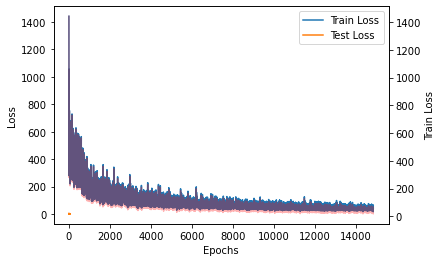

In [6]:
import matplotlib.pyplot as plt

# Plot dell'andamento della perdita
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Crea un secondo asse y per la perdita di addestramento
plt.twinx()
plt.plot(train_loss_list, 'r', alpha=0.3)  # Usiamo il colore rosso per la perdita di addestramento
plt.ylabel('Train Loss')

plt.show()

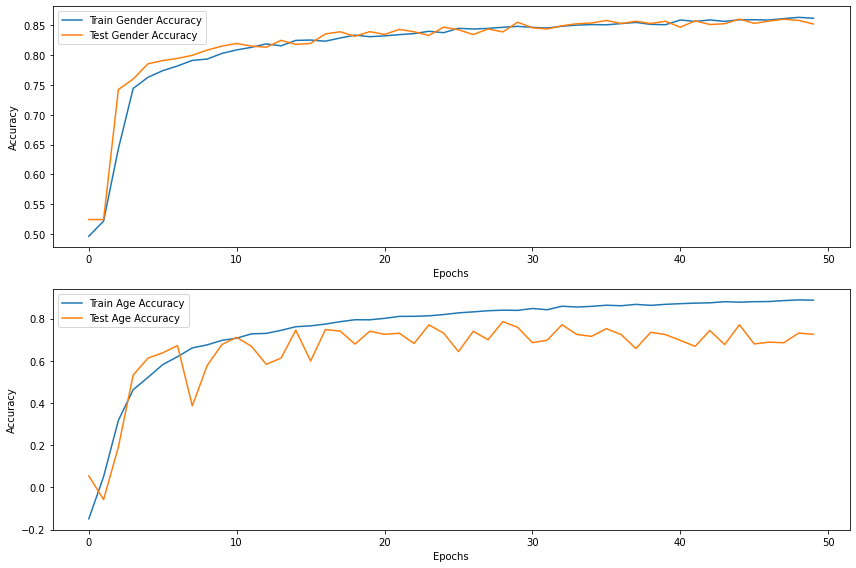

In [7]:
# Plot dell'andamento dell'accuratezza
plt.figure(figsize=(12, 8))

# Plot per il genere
plt.subplot(2, 1, 1)
plt.plot(train_gender_accuracy_list, label='Train Gender Accuracy')
plt.plot(test_gender_accuracy_list, label='Test Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot per l'età
plt.subplot(2, 1, 2)
plt.plot(train_age_accuracy_list, label='Train Age Accuracy')
plt.plot(test_age_accuracy_list, label='Test Age Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

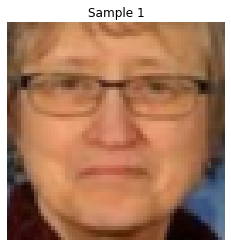

Real Age: [49.], Predicted Age: 53.19
Real Gender: Female, Predicted Gender: Male




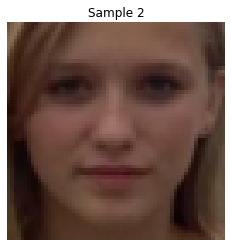

Real Age: [17.], Predicted Age: 14.25
Real Gender: Female, Predicted Gender: Female




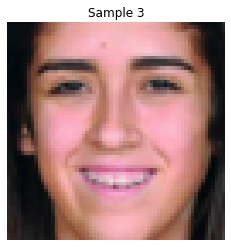

Real Age: [17.], Predicted Age: 19.73
Real Gender: Female, Predicted Gender: Female




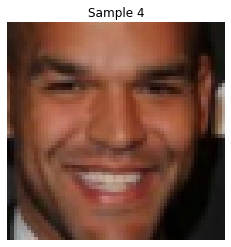

Real Age: [29.], Predicted Age: 29.30
Real Gender: Male, Predicted Gender: Male




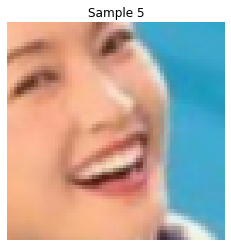

Real Age: [26.], Predicted Age: 29.99
Real Gender: Female, Predicted Gender: Female




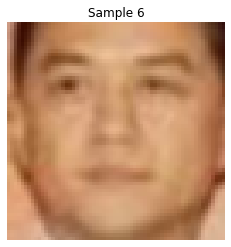

Real Age: [41.], Predicted Age: 25.05
Real Gender: Male, Predicted Gender: Male




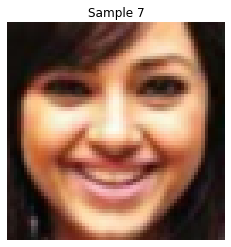

Real Age: [26.], Predicted Age: 21.24
Real Gender: Female, Predicted Gender: Female




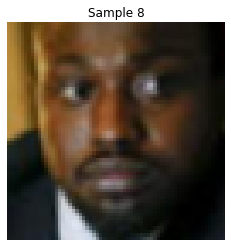

Real Age: [39.], Predicted Age: 24.31
Real Gender: Male, Predicted Gender: Male




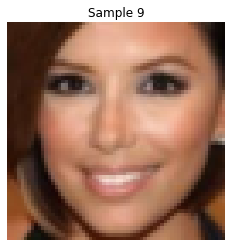

Real Age: [29.], Predicted Age: 23.21
Real Gender: Female, Predicted Gender: Female




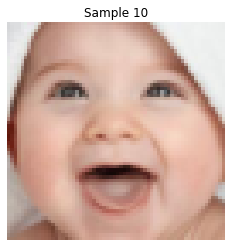

Real Age: [1.], Predicted Age: 0.30
Real Gender: Female, Predicted Gender: Male




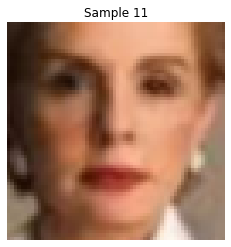

Real Age: [63.], Predicted Age: 34.43
Real Gender: Female, Predicted Gender: Female




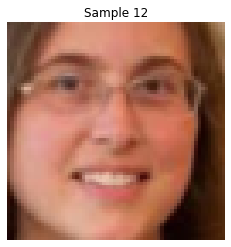

Real Age: [28.], Predicted Age: 26.64
Real Gender: Female, Predicted Gender: Male




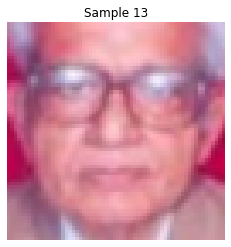

Real Age: [73.], Predicted Age: 63.47
Real Gender: Male, Predicted Gender: Male




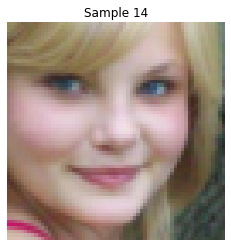

Real Age: [18.], Predicted Age: 9.05
Real Gender: Female, Predicted Gender: Female




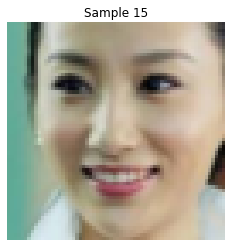

Real Age: [28.], Predicted Age: 21.35
Real Gender: Female, Predicted Gender: Female




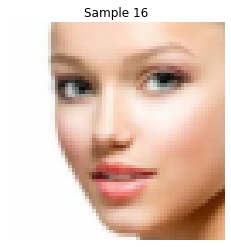

Real Age: [23.], Predicted Age: 17.69
Real Gender: Female, Predicted Gender: Female




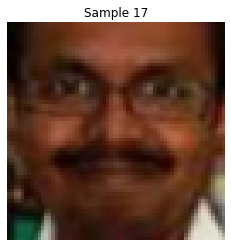

Real Age: [35.], Predicted Age: 43.75
Real Gender: Male, Predicted Gender: Male




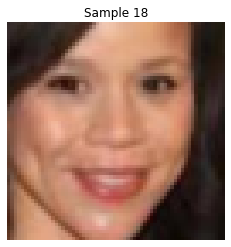

Real Age: [22.], Predicted Age: 18.25
Real Gender: Female, Predicted Gender: Female




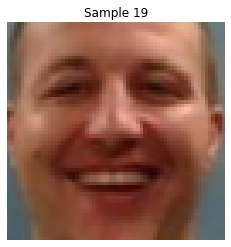

Real Age: [34.], Predicted Age: 45.97
Real Gender: Male, Predicted Gender: Male




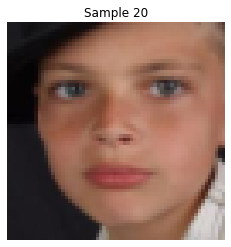

Real Age: [9.], Predicted Age: 11.76
Real Gender: Male, Predicted Gender: Female




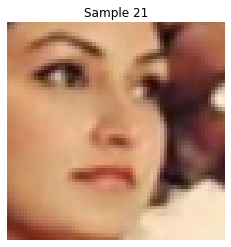

Real Age: [28.], Predicted Age: 22.56
Real Gender: Female, Predicted Gender: Female




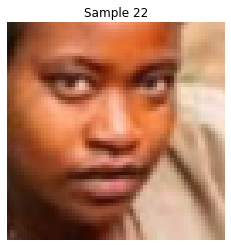

Real Age: [25.], Predicted Age: 26.75
Real Gender: Female, Predicted Gender: Male




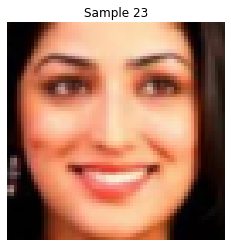

Real Age: [23.], Predicted Age: 23.88
Real Gender: Female, Predicted Gender: Female




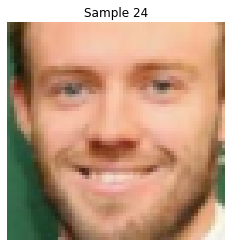

Real Age: [28.], Predicted Age: 29.46
Real Gender: Male, Predicted Gender: Male




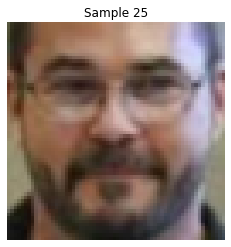

Real Age: [49.], Predicted Age: 34.80
Real Gender: Male, Predicted Gender: Male




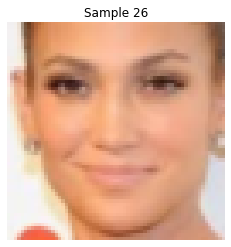

Real Age: [35.], Predicted Age: 23.56
Real Gender: Female, Predicted Gender: Female




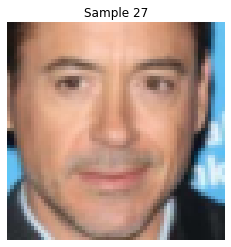

Real Age: [50.], Predicted Age: 30.69
Real Gender: Male, Predicted Gender: Male




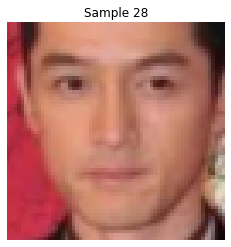

Real Age: [32.], Predicted Age: 23.33
Real Gender: Male, Predicted Gender: Male




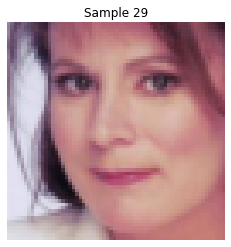

Real Age: [52.], Predicted Age: 28.15
Real Gender: Female, Predicted Gender: Female




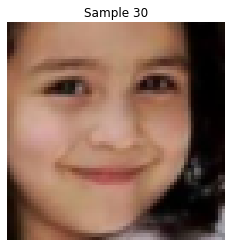

Real Age: [7.], Predicted Age: 4.96
Real Gender: Female, Predicted Gender: Female




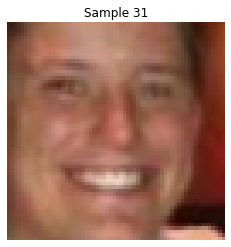

Real Age: [29.], Predicted Age: 26.43
Real Gender: Male, Predicted Gender: Male




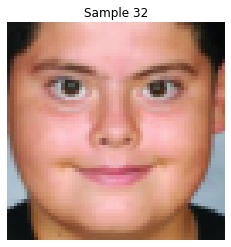

Real Age: [14.], Predicted Age: 9.41
Real Gender: Male, Predicted Gender: Female




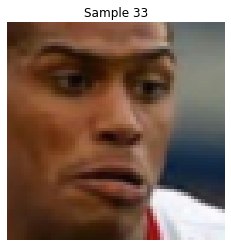

Real Age: [27.], Predicted Age: 24.67
Real Gender: Male, Predicted Gender: Male




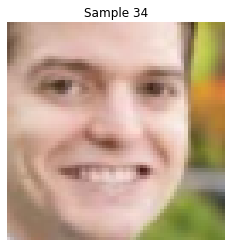

Real Age: [34.], Predicted Age: 22.13
Real Gender: Male, Predicted Gender: Female




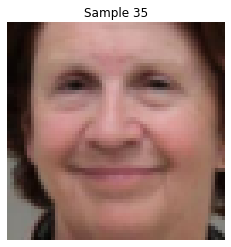

Real Age: [78.], Predicted Age: 55.31
Real Gender: Female, Predicted Gender: Female




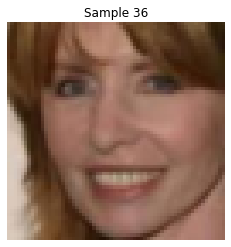

Real Age: [40.], Predicted Age: 35.10
Real Gender: Female, Predicted Gender: Female




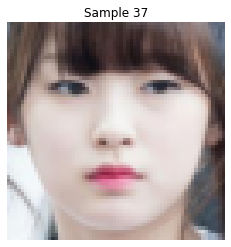

Real Age: [18.], Predicted Age: 14.18
Real Gender: Female, Predicted Gender: Male




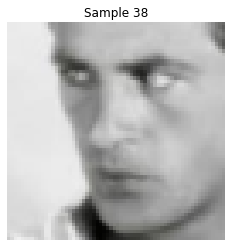

Real Age: [35.], Predicted Age: 20.23
Real Gender: Male, Predicted Gender: Male




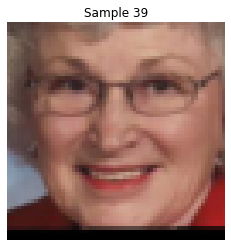

Real Age: [85.], Predicted Age: 53.43
Real Gender: Female, Predicted Gender: Female




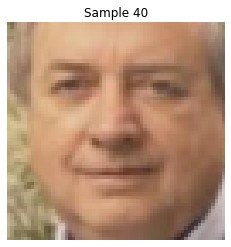

Real Age: [52.], Predicted Age: 47.61
Real Gender: Male, Predicted Gender: Male




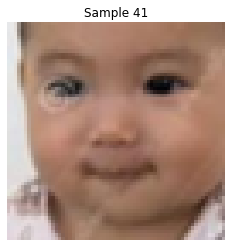

Real Age: [1.], Predicted Age: 2.88
Real Gender: Female, Predicted Gender: Male




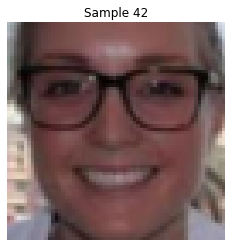

Real Age: [26.], Predicted Age: 26.12
Real Gender: Female, Predicted Gender: Male




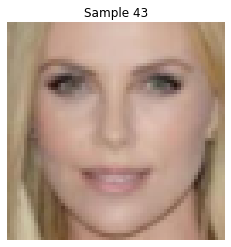

Real Age: [32.], Predicted Age: 24.90
Real Gender: Female, Predicted Gender: Female




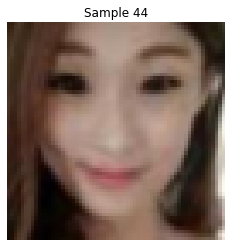

Real Age: [27.], Predicted Age: 16.98
Real Gender: Female, Predicted Gender: Female




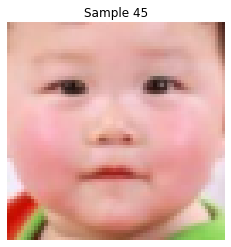

Real Age: [2.], Predicted Age: 4.10
Real Gender: Male, Predicted Gender: Male




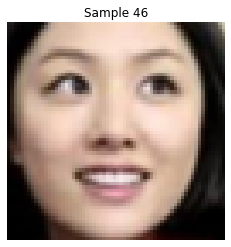

Real Age: [26.], Predicted Age: 26.79
Real Gender: Female, Predicted Gender: Female




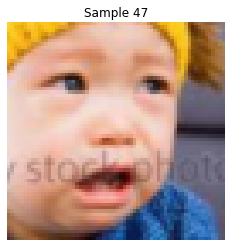

Real Age: [2.], Predicted Age: 4.71
Real Gender: Male, Predicted Gender: Male




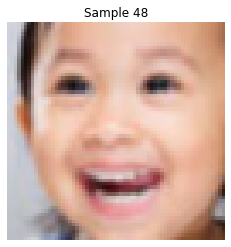

Real Age: [2.], Predicted Age: 6.76
Real Gender: Female, Predicted Gender: Female




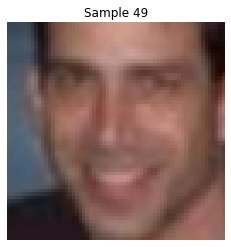

Real Age: [34.], Predicted Age: 29.48
Real Gender: Male, Predicted Gender: Male




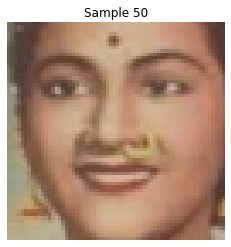

Real Age: [26.], Predicted Age: 30.17
Real Gender: Female, Predicted Gender: Female




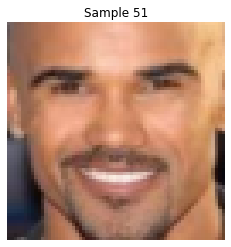

Real Age: [41.], Predicted Age: 36.67
Real Gender: Male, Predicted Gender: Male




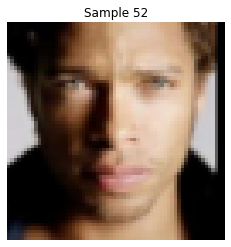

Real Age: [30.], Predicted Age: 26.04
Real Gender: Male, Predicted Gender: Male




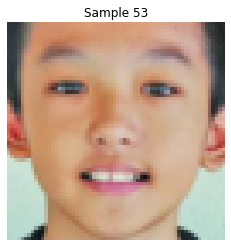

Real Age: [11.], Predicted Age: 7.18
Real Gender: Male, Predicted Gender: Male




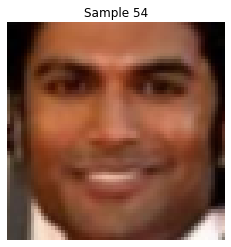

Real Age: [29.], Predicted Age: 29.08
Real Gender: Male, Predicted Gender: Male




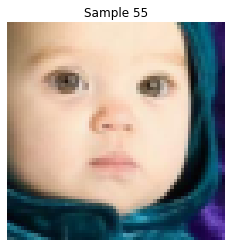

Real Age: [1.], Predicted Age: 4.99
Real Gender: Male, Predicted Gender: Female




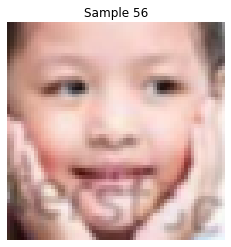

Real Age: [5.], Predicted Age: 3.53
Real Gender: Female, Predicted Gender: Male




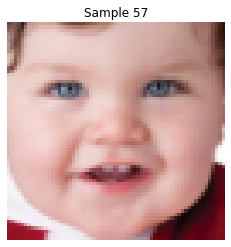

Real Age: [2.], Predicted Age: -2.01
Real Gender: Male, Predicted Gender: Male




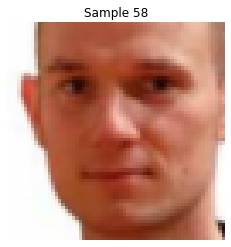

Real Age: [35.], Predicted Age: 21.78
Real Gender: Male, Predicted Gender: Male




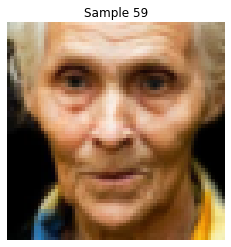

Real Age: [96.], Predicted Age: 79.78
Real Gender: Female, Predicted Gender: Female




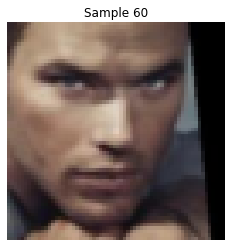

Real Age: [28.], Predicted Age: 21.43
Real Gender: Male, Predicted Gender: Male




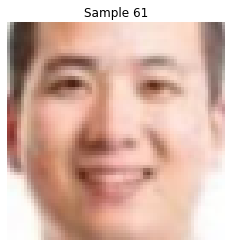

Real Age: [30.], Predicted Age: 27.12
Real Gender: Male, Predicted Gender: Male




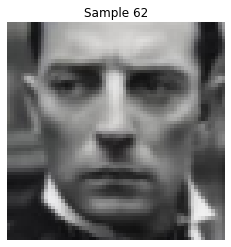

Real Age: [34.], Predicted Age: 49.44
Real Gender: Male, Predicted Gender: Male




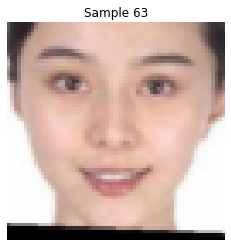

Real Age: [26.], Predicted Age: 16.96
Real Gender: Female, Predicted Gender: Male




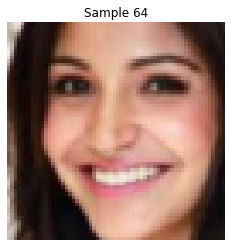

Real Age: [21.], Predicted Age: 20.47
Real Gender: Female, Predicted Gender: Female




In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Valuta il modello sul set di test
model.eval()
with torch.no_grad():
    for i, (inputs, gender_labels, age_labels) in enumerate(test_loader):
        age_labels = age_labels.float().view(-1, 1)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            gender_labels = gender_labels.cuda()
            age_labels = age_labels.cuda()
        gender_output, age_output = model(inputs)

        # Converte le predizioni in età e genere previsti
        predicted_age = age_output.cpu().numpy()
        predicted_gender = torch.argmax(gender_output, dim=1).cpu().numpy()

        # Età e genere reali
        real_age = age_labels.cpu().numpy()
        real_gender = gender_labels.cpu().numpy()

        # Stampa alcuni esempi
        if i % 100 == 0:
            for j in range(len(inputs)):
                # Visualizza l'immagine
                img = np.transpose(inputs[j].cpu().numpy(), (1, 2, 0))
                plt.imshow(img)
                plt.title(f"Sample {i * len(inputs) + j + 1}")
                plt.axis('off')
                plt.show()

                # Stampa età e genere reali e predetti
                print(f"Real Age: {real_age[j]}, Predicted Age: {predicted_age[j][0]:.2f}")
                print(f"Real Gender: {'Male' if real_gender[j] == 0 else 'Female'}, Predicted Gender: {'Male' if predicted_gender[j] == 0 else 'Female'}")
                print("\n")
